In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split , Dataset
from torchvision import models, transforms, datasets
from torchvision import models
from torchvision.models import EfficientNet_B7_Weights
from PIL import Image
from sklearn.metrics import confusion_matrix
import csv

In [ ]:
train_dir = '/kaggle/input/arabic-letter-classification/Final_Arabic_Alpha_dataset/train'
num_classes = 65
image_shape = (224, 224)

In [ ]:
class MakeDataset(Dataset):
    def __init__(self, root_folder, transform=None):
        self.root_folder = root_folder
        self.transform = transform
        self.classes = sorted(os.listdir(root_folder), key=lambda x: int(x))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = self.make_dataset()

    def make_dataset(self):
        images = []
        for label in self.classes:
            label_folder = os.path.join(self.root_folder, label)
            for image_name in os.listdir(label_folder):
                image_path = os.path.join(label_folder, image_name)
                item = (image_path, self.class_to_idx[label])
                images.append(item)
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path, label = self.images[index]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(image_shape),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
dataset = MakeDataset(train_dir, transform=transform)


In [ ]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
batch_size = 8

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def show_images(images, labels, ncols=8):
    figure, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(15, 2))
    for i, ax in enumerate(axes):
        ax.imshow(np.transpose(images[i], (1, 2, 0)))
        ax.set_title(f'Class: {labels[i]}')
        ax.axis('off')

In [ ]:
data_iter = iter(train_loader)
images, labels = data_iter.__next__()

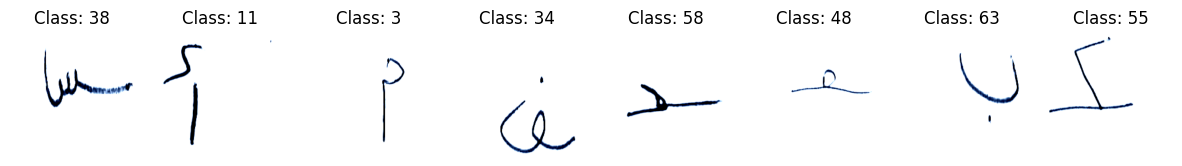

In [30]:
show_images(images, labels)
plt.show()

In [31]:
# Assuming the classifier attribute is 'classifier', get the last layer in the Sequential
last_layer = list(model.classifier.children())[-1]


# Replace it with the correct attribute name
if isinstance(last_layer, nn.Linear):
    in_features = last_layer.in_features
    model.classifier[-1] = nn.Linear(in_features, num_classes)
else:
    raise ValueError("The last layer of the classifier is not Linear, please adjust the code accordingly.")

In [32]:
model = models.efficientnet_b7(weights=None)  # We don't load any pretrained weights initially


In [33]:
# Specify the path to your .pth file
weights_path = '/kaggle/input/efficientnet-b7-lukemelas/efficientnet_b7_lukemelas-c5b4e57e.pth'

# Load the model weights
model.load_state_dict(torch.load(weights_path))


/tmp/ipykernel_23/2452538063.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path))


<All keys matched successfully>

In [34]:
model.eval()


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [35]:
from PIL import Image
import torch
from torchvision import models, transforms

# Load your image
image_path = '/kaggle/input/arabic-letter-classification/Final_Arabic_Alpha_dataset/train/0/user001_heh_middle_042.png'
image = Image.open(image_path)

# Convert grayscale to RGB
if image.mode != 'RGB':
    image = image.convert('RGB')

# Define preprocessing steps
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Apply preprocessing to the image
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)

# Move the model and input to the same device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.efficientnet_b7(weights=None)  # Replace with your model initialization and loading code
model.load_state_dict(torch.load('/kaggle/input/efficientnet-b7-lukemelas/efficientnet_b7_lukemelas-c5b4e57e.pth'))
model.to(device)
input_batch = input_batch.to(device)

# Make a prediction
with torch.no_grad():
    model.eval()
    output = model(input_batch)

print(output)


/tmp/ipykernel_23/567665496.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/efficientnet-b7-lukemelas/efficientnet_b7_lu

tensor([[-6.0776e-02, -1.8337e-01, -2.3566e-01, -1.6719e+00,  1.2867e-01,
          1.1122e+00, -6.1951e-01, -2.4758e-01,  1.2116e-01, -4.0880e-02,
         -1.8776e-01, -1.9709e-01,  4.2512e-01, -1.1316e-02,  2.7216e-01,
          9.0589e-01,  2.8765e-01, -2.6854e-01,  5.2555e-01,  5.0347e-02,
          8.9830e-01,  7.3006e-01,  1.9284e-01,  5.9178e-01,  1.2081e+00,
         -3.1947e-01, -1.5896e-01, -2.1200e-01, -5.4651e-01,  1.4640e-01,
         -4.1101e-01, -3.7165e-01, -1.9872e-02, -6.2972e-01, -5.0502e-02,
         -4.8647e-01, -9.2045e-01, -1.0699e+00,  5.3242e-01, -5.2509e-01,
         -1.2070e+00, -3.4940e-01, -9.9681e-02, -7.3735e-01, -9.0575e-01,
         -5.8980e-02, -1.1098e+00,  6.3949e-01, -6.6828e-01, -4.7692e-01,
         -1.3708e-01, -5.8265e-01,  7.8773e-01,  3.6375e-01, -1.2415e+00,
         -4.6650e-01, -2.4176e-01, -9.6349e-01,  1.2154e-01,  1.2393e+00,
         -2.1874e-01, -7.8152e-01, -7.5723e-01,  5.4050e-01,  7.0795e-01,
         -3.5746e-01,  8.8458e-02, -4.

In [36]:
# Assuming the classifier attribute is 'classifier', get the last layer in the Sequential
last_layer = list(model.classifier.children())[-1]


# Replace it with the correct attribute name
if isinstance(last_layer, nn.Linear):
    in_features = last_layer.in_features
    model.classifier[-1] = nn.Linear(in_features, num_classes)
else:
    raise ValueError("The last layer of the classifier is not Linear, please adjust the code accordingly.")

In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [39]:
torch.cuda.empty_cache()

In [40]:
model = model.to(device)

In [41]:
num_epochs = 10
desired_training_accuracy = 99.999
early_stopping_threshold = 5  
early_stopping_counter = 0
best_val_loss = float('inf')

In [69]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
predictions = []
targets = []

In [71]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

        # Print training loss and accuracy every 100 batches
        if i % 100 == 99:
            print(f'Epoch {epoch + 1}/{num_epochs}, Batch {i + 1}/{len(train_loader)}, '
                  f'Training Loss: {running_loss / 100}, Training Accuracy: {100 * correct_train / total_train}')
            running_loss = 0.0

    # Calculate training accuracy after the epoch
    training_accuracy = correct_train / total_train

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

            # Append predictions and targets for confusion matrix
            predictions.append(predicted_val.cpu().numpy())
            targets.append(labels.cpu().numpy())

    # Calculate validation accuracy after the epoch
    validation_accuracy = correct_val / total_val
    average_val_loss = val_running_loss / len(val_loader)

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {running_loss / len(train_loader)}, '
          f'Training Accuracy: {100 * training_accuracy}%, '
          f'Validation Loss: {average_val_loss}, '
          f'Validation Accuracy: {100 * validation_accuracy}%')

    # Append training and validation metrics for plotting
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(training_accuracy)
    val_losses.append(average_val_loss)
    val_accuracies.append(validation_accuracy)

    scheduler.step()

Epoch 1/10, Batch 100/4256, Training Loss: 0.2077931173145771, Training Accuracy: 93.125
Epoch 1/10, Batch 200/4256, Training Loss: 0.1864099372504279, Training Accuracy: 93.8125
Epoch 1/10, Batch 300/4256, Training Loss: 0.1640283714607358, Training Accuracy: 94.0
Epoch 1/10, Batch 400/4256, Training Loss: 0.1411011992674321, Training Accuracy: 94.4375
Epoch 1/10, Batch 500/4256, Training Loss: 0.16106826387811451, Training Accuracy: 94.525
Epoch 1/10, Batch 600/4256, Training Loss: 0.13712332512252032, Training Accuracy: 94.79166666666667
Epoch 1/10, Batch 700/4256, Training Loss: 0.21058982150629163, Training Accuracy: 94.625
Epoch 1/10, Batch 800/4256, Training Loss: 0.12867029168177396, Training Accuracy: 94.890625
Epoch 1/10, Batch 900/4256, Training Loss: 0.18348339006537573, Training Accuracy: 94.77777777777777
Epoch 1/10, Batch 1000/4256, Training Loss: 0.1830270247417502, Training Accuracy: 94.7125
Epoch 1/10, Batch 1100/4256, Training Loss: 0.18868709125556052, Training Accu

KeyboardInterrupt: 

In [65]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f'Test Accuracy: {100 * test_accuracy}%')

Test Accuracy: 92.90580220812778%


In [44]:
# Plotting loss and accuracy curves
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

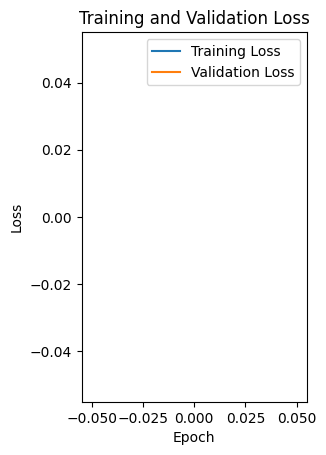

In [72]:
# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

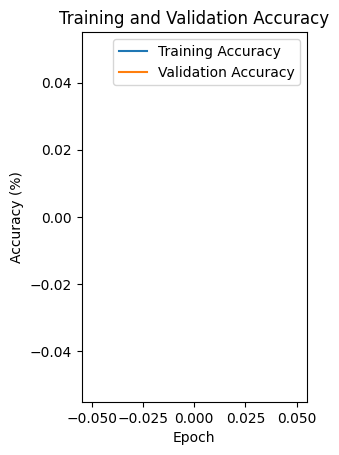

In [73]:
# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

In [74]:
# Confusion Matrix
conf_matrix = confusion_matrix(np.concatenate(predictions), np.concatenate(targets))
print('Confusion Matrix:')

# Print all numbers in the confusion matrix
print('Confusion Matrix:')
for row in conf_matrix:
    for value in row:
        print(value, end=' ')
    print()

ValueError: need at least one array to concatenate

In [75]:
plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

NameError: name 'conf_matrix' is not defined

<Figure size 1000x800 with 0 Axes>